<a href="https://colab.research.google.com/github/yashuvishnalia/tensorflow-basic-test-code/blob/master/colab_test1_nifty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [18]:
import os
os.listdir('/content/gdrive/My Drive/Colab Notebooks/')

['Copy of first_steps_with_tensor_flow.ipynb',
 'Untitled0.ipynb',
 'colab_test0_nifty.ipynb',
 'modified_intraday_2017_niftyAllData4-10.pkl',
 'colab_test1_nifty.ipynb']

In [19]:
from __future__ import print_function
import pandas as pd

print(pd.__version__)

panel = pd.read_pickle(r'/content/gdrive/My Drive/Colab Notebooks/\
modified_intraday_2017_niftyAllData4-10.pkl')#,parse_dates=[1])#,date_parser=True)#index_col=False)--not working
panel

0.23.4


<class 'pandas.core.panel.Panel'>
Dimensions: 101 (items) x 89280 (major_axis) x 5 (minor_axis)
Items axis: ACC to ZEEL
Major_axis axis: 2017-01-02 04:01:00+00:00 to 2017-12-29 10:00:00+00:00
Minor_axis axis: open to volume

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM,Dense, Activation,Dropout

# For custom metrics
import keras.backend as K

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn import preprocessing

In [114]:
scaler=preprocessing.MinMaxScaler()
panel['HINDUNILVR'].head()

,open,high,low,close,volume
2017-01-02 04:01:00+00:00,823.60,823.80,823.25,823.75,1699.0
2017-01-02 04:02:00+00:00,824.35,825.50,824.30,824.65,365.0
2017-01-02 04:03:00+00:00,825.00,825.65,824.80,825.05,324.0
2017-01-02 04:04:00+00:00,824.90,825.00,824.30,824.45,564.0
2017-01-02 04:05:00+00:00,824.50,825.60,824.50,825.60,385.0


In [0]:
# callbacks = [
#   # Interrupt training if `val_loss` stops improving for over 2 epochs
#   tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
#   # Write TensorBoard logs to `./logs` directory
#   tf.keras.callbacks.TensorBoard(log_dir='./logs')
# ]


In [0]:
def train(df,batch_size=32,back_step=1,forward=1):
  df['PCT_change']=((df['close']-df['open'])/df['open'])*100
  df['HL_PCT']= ((df['high']-df['low'])/df['close'])*100
  df_=df[['close','volume','PCT_change','HL_PCT']]
  df_['pct']=df['close'].pct_change()
  new_order = [0,4,1,2,3]
  df_=df_[df_.columns[new_order]]
  df_.fillna(0,inplace=True)
  print(df_.head())

  data_=np.array(df_)[0:10000]#change no. of data examples

  global scaler
  scaler=scaler.fit(data_)
  data = scaler.transform(data_)
  early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=50)#monitor='val_loss'
  
  def feature_and_label(X,y,back_step=1,forward_step=1):
      X_ = np.array([X[i:i+back_step][:] for i in range(len(X)-back_step+1-forward_step)])#index(0-1009)=len1010
      #for continuous data prediction
  #     y_ = np.array([y[i+back_step:i+back_step+forward_step] 
  #                    for i in range(len(y)-back_step+1-forward_step)])#index(1-1010)=len1010
      #prediction at forward_step 
      y_ = np.array([y[i+back_step+forward_step-1] 
                     for i in range(len(y)-back_step+1-forward_step)])    
      return X_,y_
  def data_prep(data_t,back_step=1,forward=1,batch_size=32):
      ''' change data_t[:,1:2],data_t[:,0] accordingly '''
      X_,y_ = feature_and_label(data_t[:,0:3],data_t[:,0],back_step,forward)
      X_=X_.reshape(len(X_),len(X_[0]),len(X_[0][0]))
      y_=y_.reshape(len(y_),1)#have to change if we have other dimen of y
      print("shape X, y : ",X_.shape,y_.shape,X_[0],y_[0])

      m=int(len(X_)/batch_size)
      ratio=(int(m*0.8))*batch_size
      train_X,test_X=X_[:ratio],X_[ratio:m*batch_size]
      train_y,test_y=y_[:ratio],y_[ratio:m*batch_size]
      print("test x,y and train x, y shape : ",test_X.shape,test_y.shape,train_X.shape,train_y.shape)

      return train_X,train_y,test_X,test_y

  train_X,train_y,test_X,test_y = \
  data_prep(data_t=data,back_step=back_step,forward=1,batch_size=batch_size)
  
  def build_neural_net(batch_size,back_step=1,n_feature=1):
    # expected input data shape: (batch_size, timesteps, data_dim)
    model = Sequential()
    model.add(LSTM(128, return_sequences=True,batch_input_shape=(batch_size,back_step, n_feature),
                   stateful=True,))  # returns a sequence of vectors of dimension 32
    model.add(Dropout(0.1))
    model.add(LSTM(256))#, return_sequences=True, stateful=True,))  # returns a sequence of vectors of dimension 32
#     model.add(LSTM())  # return a single vector of dimension 32
    model.add(Dropout(0.1))
    model.add(Dense(64))
    model.add(Dense(1))
#     def mean_pred(y_true, y_pred):
#         return K.mean(y_pred)

    # For a mean squared error regression problem
    model.compile(optimizer='adam',
                  loss='mse',
                 metrics=['accuracy','mae'])#, mean_pred])
    return model
  def train_(train_X,train_y,back_step,n_feature=1,batch_size=32,model=False):
      if not model:
          model = build_neural_net(batch_size,back_step,n_feature)
      model.fit(train_X,train_y,
            batch_size=batch_size, epochs=150, shuffle=False, verbose=0,
                      callbacks=[early_stop],
  #           validation_data=(x_val, y_val)
               )
      return model
  model = train_(train_X,train_y,back_step,n_feature=3,batch_size=batch_size)
  return model,train_X,train_y,test_X,test_y

In [0]:
def plot_graph(model,pred,test_y):
  global scaler
  global ticker
  def scale_for_c_price(scaler=scaler):
      scale=preprocessing.MinMaxScaler()
      scale.min_,scale.scale_=scaler.min_[0],scaler.scale_[0]
      return scale
  scale = scale_for_c_price()
  p=scale.inverse_transform(pred)
  y=scale.inverse_transform(test_y)
  def price_plot(p=p,y=y,ticker=ticker):
      plt.figure(figsize=(15,4))
      plt.plot(range(len(pred)),p,label='p')
      plt.plot(range(len(test_y)),y,label='y')
      plt.title('model for 3 feature(p,pct,v) and 100 epoch for {}'.format(ticker))
      plt.ylabel('price')
      plt.xlabel('minute')
      plt.grid()
      plt.legend()
      plt.show()
      return p,y
  price_plot()
  p=p[:200].reshape(-1)
  y=y[:200].reshape(-1)
  df_yp=pd.DataFrame({'p':p,'y':y})
  df_yp['diff']=df_yp['y']-df_yp['p']  
  def loss_plot(model=model):
    model_dict = model.history.history
    np_loss=np.array(model_dict['loss'])
    np_loss = np.sqrt(np_loss)
    plt.plot(np_loss)
    plt.ylabel('rmse loss')
    plt.xlabel('epoch')
    plt.grid()
    plt.show()
    print('minumum loss: {} '.format(np.amin(np_loss)))
    print('at epoch : {}'.format(np.where(np_loss==np.amin(np_loss))))
  loss_plot()
  print(df_yp.describe())
  def diff_plot(df_yp=df_yp):
    plt.figure(figsize=(15,5))
    plt.title('graph for first 200 minutes')
    ax1 = plt.subplot2grid((3, 3), (0, 0), rowspan=2,colspan=3)
    ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=3)

    ax1.plot(df_yp.index,df_yp.y,label='y')
    ax1.plot(df_yp.index,df_yp.p,label='p')
    ax2.bar(df_yp.index,df_yp['diff'])
    ax1.grid()
    ax2.grid()
    ax2.set_xlabel('time (m)')
    ax2.set_ylabel('Error')
    ax1.legend()
    plt.show()
  diff_plot()
  return df_yp

In [117]:
ticker='INFY'
df=panel[ticker]
# df['date'] = pd.to_datetime(df['date'],utc=True)
# df.set_index('date',inplace=True)
df.head(3)#,df.index.dtype

,open,high,low,close,volume,PCT_change,HL_PCT
2017-01-02 04:01:00+00:00,1005.25,1006.35,1005.20,1005.4,2517.0,0.014922,0.114382
2017-01-02 04:02:00+00:00,1005.65,1006.65,1005.55,1005.6,2523.0,-0.004972,0.109387
2017-01-02 04:03:00+00:00,1005.65,1006.90,1005.25,1006.9,1850.0,0.124298,0.163869


In [124]:
model,train_X,train_y,test_X,test_y=train(df,batch_size=64,back_step=1,forward=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


                            close       pct  volume  PCT_change    HL_PCT
2017-01-02 04:01:00+00:00  1005.4  0.000000  2517.0    0.014922  0.114382
2017-01-02 04:02:00+00:00  1005.6  0.000199  2523.0   -0.004972  0.109387
2017-01-02 04:03:00+00:00  1006.9  0.001293  1850.0    0.124298  0.163869
2017-01-02 04:04:00+00:00  1007.3  0.000397  2512.0    0.029791  0.079420
2017-01-02 04:05:00+00:00  1007.7  0.000397  1964.0    0.019851  0.099236
shape X, y :  (9999, 1, 3) (9999, 1) [[0.96053898 0.46362575 0.00405893]] [0.96246391]
test x,y and train x, y shape :  (2048, 1, 3) (2048, 1) (7936, 1, 3) (7936, 1)


In [0]:
# Save entire model to a HDF5 file
model.save('my_model.h5')

# Recreate the exact same model, including weights and optimizer.
model = tf.keras.models.load_model('my_model.h5')

In [125]:
model

In [126]:
batch_size=64
pred = model.predict(test_X, batch_size=batch_size)
loss_and_metrics = model.evaluate(test_X,test_y, batch_size=batch_size)
loss_and_metrics

2048/2048 [==============================] - 0s 196us/sample - loss: 1.9071e-04 - acc: 0.0000e+00 - mean_absolute_error: 0.0098


[0.0001907140720049938, 0.0, 0.009776651]

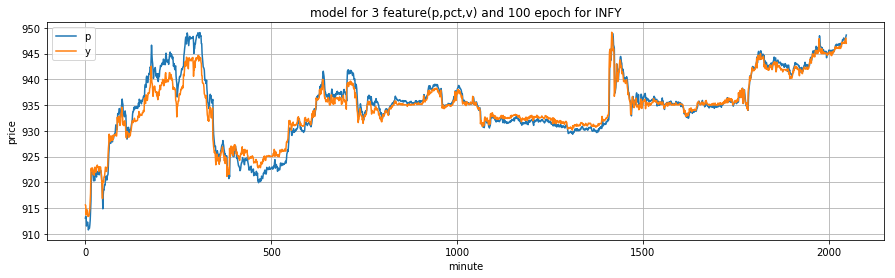

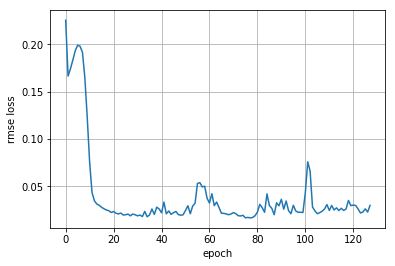

minumum loss: 0.016435636256538266 
at epoch : (array([77]),)
                p           y        diff
count  200.000000  200.000000  200.000000
mean   929.869324  929.045750   -0.823470
std      8.806179    6.839471    2.272927
min    910.752869  913.350000   -6.238489
25%    921.953629  922.950000   -2.621069
50%    931.002411  930.000000   -0.942981
75%    935.899750  933.412500    0.935257
max    946.638489  942.550000    5.979700


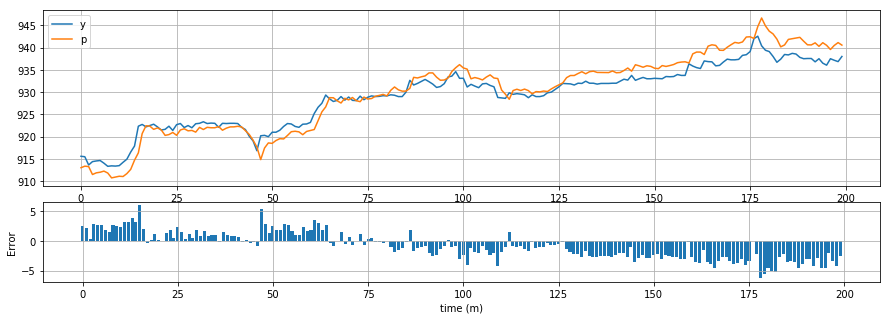

In [127]:
'''epoch = 27 
feature = price,pct,vol
'''
df_yp=plot_graph(model,pred,test_y)

In [128]:
from scipy import stats
print(stats.describe(test_y))
print(stats.describe(pred))

DescribeResult(nobs=2048, minmax=(array([0.07459095]), array([0.41915303])), mean=array([0.27884619]), variance=array([0.0031193]), skewness=array([-0.29350811]), kurtosis=array([0.57865444]))
DescribeResult(nobs=2048, minmax=(array([0.04959515], dtype=float32), array([0.41851953], dtype=float32)), mean=array([0.28167802], dtype=float32), variance=array([0.00424452], dtype=float32), skewness=array([-0.36608645], dtype=float32), kurtosis=array([0.3544278], dtype=float32))


In [129]:
# df_test = pd.DataFrame()
# df_test['test_y'] = pd.Series(test_y)#,index=df_test.index)
# df_test=pd.Series(test_y)
data={'test_y':list(test_y.reshape(-1)),'pred':list(pred.reshape(-1))}
df_test = pd.DataFrame(data)
df_test.describe()

,test_y,pred
count,2048.000000,2048.000000
mean,0.278846,0.281678
std,0.055851,0.065150
min,0.074591,0.049595
25%,0.253609,0.248206
50%,0.282964,0.285252
75%,0.306545,0.319393
max,0.419153,0.418520


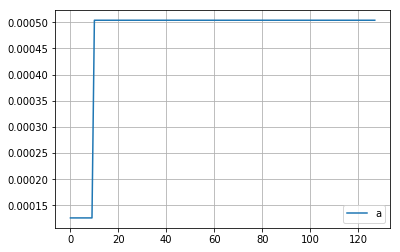

In [130]:
'''
why accuracy isn't changing much
- this accuracy for training data
'''
plt.plot(model.history.history['acc'],label='a')
# plt.plot(model.history.history['mean_absolute_error'],label='mae')
plt.grid()
plt.legend()
plt.show()

In [131]:
# mse, _ = model.evaluate(test_X,test_y, batch_size=batch_size)
rmse = np.sqrt(loss_and_metrics[0])
print('Root Mean Square Error on test set: {}'.format(round(rmse, 3)))

Root Mean Square Error on test set: 0.014


In [132]:
df_yp.head()

,p,y,diff
0,913.036194,915.60,2.563806
1,913.378967,915.50,2.121033
2,913.291382,913.65,0.358618
3,911.509155,914.40,2.890845
4,911.881653,914.55,2.668347


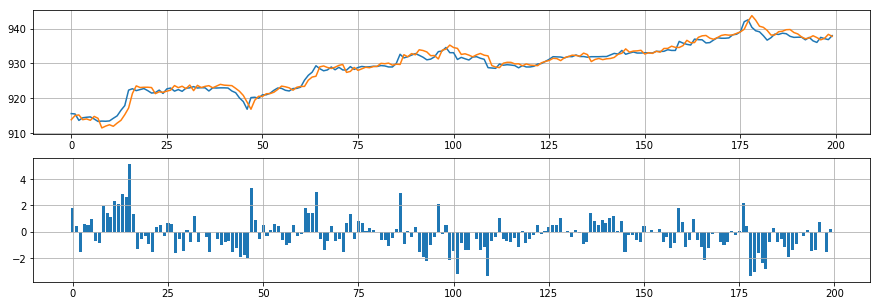

In [98]:
plt.figure(figsize=(15,5))
plt.subplot(211)
plt.plot(df_yp.index,df_yp.y)
plt.plot(df_yp.index,df_yp.p)
plt.grid()
plt.subplot(212)
plt.bar(df_yp.index,df_yp['diff'])
plt.grid()

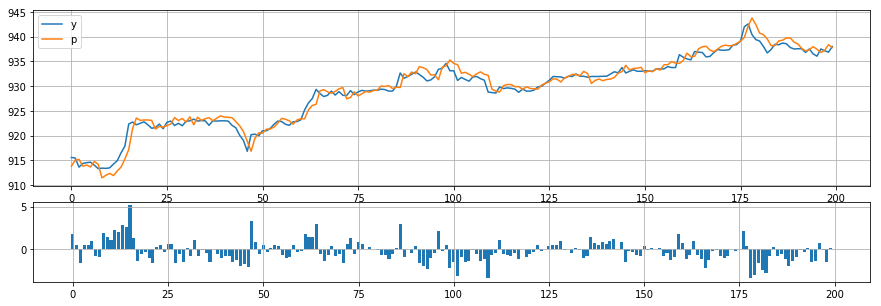

In [111]:
plt.figure(figsize=(15,5))
ax1 = plt.subplot2grid((3, 3), (0, 0), rowspan=2,colspan=3)
ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=3)

ax1.plot(df_yp.index,df_yp.y,label='y')
ax1.plot(df_yp.index,df_yp.p,label='p')
ax2.bar(df_yp.index,df_yp['diff'])
ax1.grid()
ax2.grid()
ax1.legend()
plt.show()

In [0]:
'''===================================================end of session===================================================='''
'''================================below is rough work============================='''

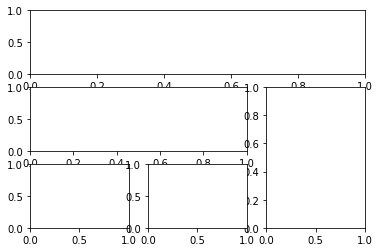

In [99]:
ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3)
ax2 = plt.subplot2grid((3, 3), (1, 0), colspan=2)
ax3 = plt.subplot2grid((3, 3), (1, 2), rowspan=2)
ax4 = plt.subplot2grid((3, 3), (2, 0))
ax5 = plt.subplot2grid((3, 3), (2, 1))


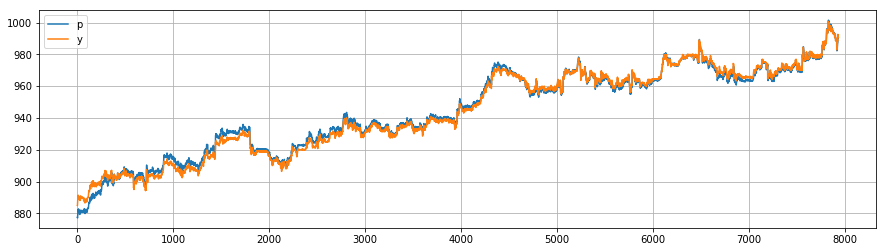

(array([[877.4719 ],
        [877.2983 ],
        [877.134  ],
        ...,
        [991.1342 ],
        [990.2084 ],
        [990.47125]], dtype=float32), array([[884.95],
        [885.05],
        [886.6 ],
        ...,
        [990.5 ],
        [991.05],
        [992.  ]]))

In [0]:
pred = model.predict(train_X, batch_size=batch_size)
scale=scale_for_c_price(scaler)
pred_plot(pred,train_y,scale)

In [0]:
#how to use global
a=0
def first():
  global a
  a=5
  print('f',a)
print('o',a)
def second():
  global a
  print('s',a)
  a=4
  print('s',a)
  def third(a=a):
    print(a)
    a=3
    print(a)
  third()

first()
print('o',a)
second()
print('o',a)

o 0
f 5
o 5
s 5
s 4
4
3
o 4


In [0]:
def abcd():
  a=5
  b=4
  return a,b
c=abcd()
c

(5, 4)